In [331]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt

In [332]:
def u(x,a):
    return np.exp(-a*x)

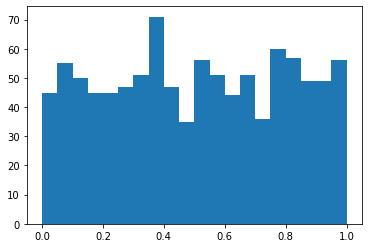

In [333]:
dist_a = cp.Uniform(0,1)
samples_a = dist_a.sample(size =1000)
a=plt.hist(samples_a,20)

In [334]:
x=np.linspace(0,10,100)

Text(0, 0.5, 'u(x,a)')

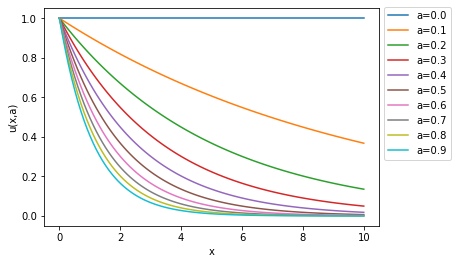

In [336]:
for i in range(10):
    a=i/10
    plt.plot(x,u(x,a),label=f'a={a}')
    plt.legend(bbox_to_anchor=(1, 1.03))
plt.xlabel('x')
plt.ylabel('u(x,a)')

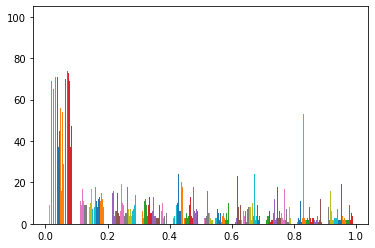

In [338]:
samples_u = [u(x,a) for a in samples_a]
a=plt.hist(samples_u)

In [345]:
E = np.mean(samples_u)
Var = np.var(samples_u)
Std = np.std(samples_u)
print(E)
print(Var)
print(Std)

0.2867389005128638
0.09607701252215221
0.3099629212053471


<ipython-input-342-5cc199ae7fd1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (1-np.exp(-x))/(x)


Text(0, 0.5, 'E(u(x))')

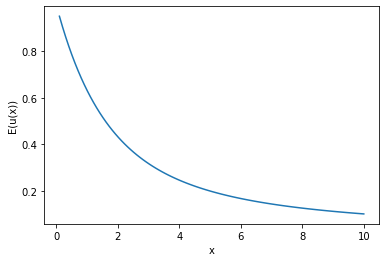

In [342]:
def exp_u(x):
    return (1-np.exp(-x))/(x)

plt.plot(x,exp_u(x))

plt.xlabel('x')
plt.ylabel('E(u(x))')

In [343]:
np.mean(exp_u(x[1:]))

0.28347667324627085

<ipython-input-342-5cc199ae7fd1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (1-np.exp(-x))/(x)


Text(0, 0.5, 'Var(u(x))')

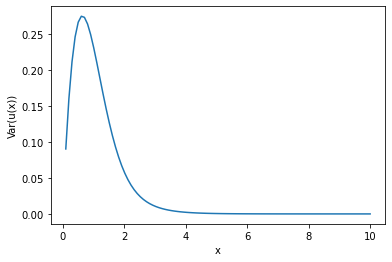

In [344]:
def var_u(x):
    return exp_u(x**2) - (exp_u(x))**2

plt.plot(x,var_u(x))

plt.xlabel('x')
plt.ylabel('Var(u(x))')

In [ ]:
##Let us try something different

In [142]:
import numpy.polynomial.hermite_e as H
from scipy.stats import norm

In [143]:
def Herm(n):
    coeffs = [0] * (n+1)
    coeffs[n] = 1
    return coeffs

In [149]:
def inner_product(h1, h2):
    return lambda x: H.hermeval(x,H.hermemul(h1,h2))

In [157]:
inner_product(0,1)

<function __main__.inner_product.<locals>.<lambda>(x)>

In [ ]:
def inner_product(h1, h2):
    return H.hermeval(x,H.hermemul(h1,h2))

In [185]:
def trapezoid_int(f,a,b,N=50):
    x = np.linspace(a,b,N+1) # N+1 points make N subintervals
    y = f(x)
    y_right = y[1:] # right endpoints
    y_left = y[:-1] # left endpoints
    dx = (b - a)/N
    T = (dx/2) * np.sum(y_right + y_left)
    return T

In [183]:
def unif_icdf(params):
    a = params[0]
    b = params[1]
    return lambda u : u * (b-a) + a

def expo_icdf(params):
    return lambda u: -np.log(1-u)

def norm_icdf(params):
    return lambda u : norm.ppf(u, loc=0, scale=1)

In [211]:
def approximate_rv_coeffs(P,h):
    ki = [0] * P
    m=P**2
    x,w = H.hermegauss(m)
    
    for i in range(0,P):
        ip=sum([inner_product(Herm(i),Herm(i))(x[idx])*w[idx] for idx in range(m)])
        integrand = lambda u : h(u) * H.hermeval(norm.ppf(u,loc=0,scale=1),Herm(i))
        ki[i]=np.sqrt(2*np.pi)/ip*trapezoid_int(integrand,0.001,1-0.001,1000)
    return ki

In [205]:
def generate_rv(ki, S):
    k=[0]*len(S)
    for i in range(len(ki)):
        k=np.add(k,ki[i]*H.hermeval(S,Herm(i)))
    return k

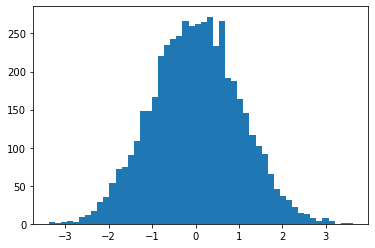

In [206]:
N=5000
S=np.random.normal(loc=0,scale=1,size=N)
out=plt.hist(S,bins=50)

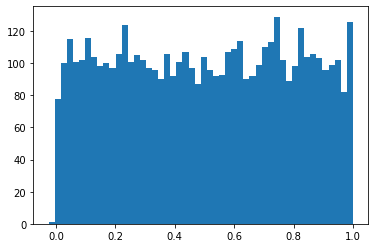

In [222]:
h=unif_icdf([0,1])
ki_uniform=approximate_rv_coeffs(13,h)
k=generate_rv(ki_uniform,S)
out = plt.hist(k, bins=50)

In [223]:
ki_uniform

[0.4990000000000002,
 0.2787554508625053,
 -0.005128476292533305,
 -0.02819935328069673,
 -0.002759564058861687,
 0.000764364827382991,
 -0.00014845002759050034,
 -5.2907946579613405e-05,
 3.567275526884871e-05,
 1.2271595198380506e-05,
 -9.226035918188392e-07,
 -1.0430068763532434e-06,
 -1.4481037273579887e-07]

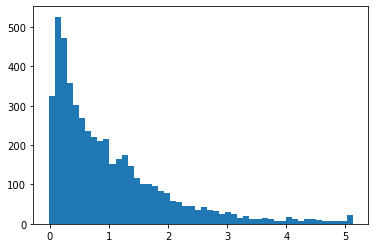

In [232]:
h=expo_icdf([0,1])
ki_expo=approximate_rv_coeffs(13,h)
k_expo=generate_rv(ki_expo,S)
out = plt.hist(k_expo, bins=50)

In [244]:
def RK4(f,ic,tspan,h):
    t=[x*h for x in range(int((max(tspan)-min(tspan))/h)+1)]
    y= [ic]
    h2 = h/2
    for i in range(0, len(t)-1):
        y1 = f(t[i],y[i])
        y2 = f(t[i]+h2,y[i]+np.multiply(h2,y1))
        y3 = f(t[i]+h2,y[i]+np.multiply(h2,y2))
        y4 = f(t[i]+h,y[i]+np.multiply(h,y3))
        y.append(y[i] + np.multiply(h/6,y1+y4+np.multiply(2, y2)+np.multiply(2,y3)))
        
    return t, y

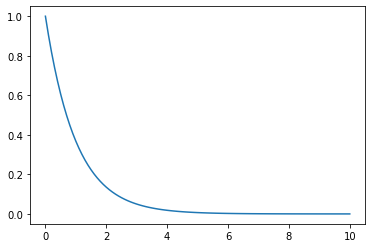

In [253]:
k=1
A = np.matrix([[-k]])
ode = lambda t, x: A*x
ic=np.matrix([1])
t,y=RK4(ode,ic,[0,10],.1)
y1=[x.item() for x in y]
plt.plot(t,y1)

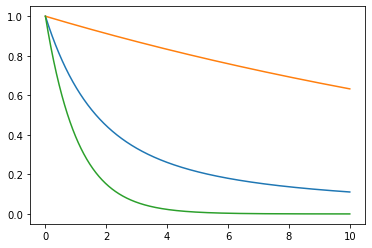

In [257]:
y_dmc = []
for k in range(1000):
    B = np.matrix([[-np.random.uniform(0,1)]])
    icb=np.matrix([1])
    odeb = lambda t, x: B*x
    t,y = RK4(odeb,icb,[0,10],.01)
    y_dmc.append([x.item() for x in y])

plt.plot(t,np.mean(y_dmc,axis=0))
plt.plot(t,np.percentile(y_dmc,axis=0,q=95))
plt.plot(t,np.percentile(y_dmc,axis=0,q=5))

In [290]:
B = np.matrix([[-0.5]])
icb=np.matrix([1])
odeb = lambda t, x: B*x
t,y = RK4(odeb,icb,[0,10],.01)
y_det=[x.item() for x in y]

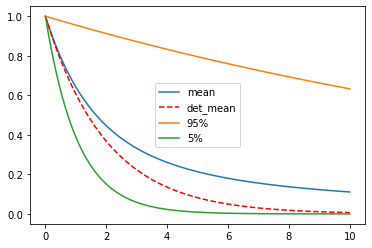

In [295]:
plt.plot(t,np.mean(y_dmc,axis=0),label='mean')
plt.plot(t,y_det,'r--',label='det_mean')
plt.plot(t,np.percentile(y_dmc,axis=0,q=95),label='95%')
plt.plot(t,np.percentile(y_dmc,axis=0,q=5),label='5%')
plt.legend()

In [300]:
def triple_product(h1,h2,h3):
    return lambda x: H.hermeval(x, H.hermemul(h1,H.hermemul(h2,h3)))

In [329]:
P=5
A=np.matrix(np.zeros((P,P)))
m=P**3
x,w=H.hermegauss(m)

for l in range(0,P):
    ip=sum([inner_product(Herm(l),Herm(l))(x[idx])*w[idx] for idx in range(m)])
    for j in range(0,P):
        for i in range(0,P):
            tp=sum([triple_product(Herm(i),Herm(j),Herm(l))(x[idx])*w[idx] for idx in range(m)])
            A[j,l]+= -1/ ip * tp * ki_uniform[i]
        
ode=lambda t, x: A*x
ic = np.matrix(np.zeros((P,1)))
ic[0]=1
t,y=RK4(ode,ic,[0,10],.01)

y_pc_mean = [x[0,0] for x in y]
y_pc_var = [x[1,0]**2 for x in y]


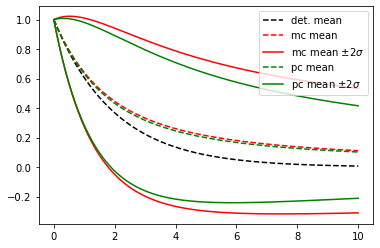

In [330]:
plt.plot(t,y_det,'k--',label='det. mean')

plt.plot(t,np.mean(y_dmc,axis=0),'r--',label='mc mean')
plt.plot(t,np.mean(y_dmc,axis=0)+2*np.sqrt(np.var(y_dmc,axis=0)),'r',label='mc mean $\pm 2 \sigma$')
plt.plot(t,np.mean(y_dmc,axis=0)-2*np.sqrt(np.var(y_dmc,axis=0)),'r')

plt.plot(t,y_pc_mean,'g--',label='pc mean')
plt.plot(t,np.add(y_pc_mean,np.multiply(2,np.sqrt(y_pc_var))),'g',label='pc mean $\pm 2 \sigma$')
plt.plot(t,np.add(y_pc_mean,np.multiply(-2,np.sqrt(y_pc_var))),'g')

plt.legend()

